In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# EM算法example算法测试
### [The EM algorithm](https://see.stanford.edu/materials/aimlcs229/cs229-notes8.pdf)

## test1: mixture of gaussians
### 1. data

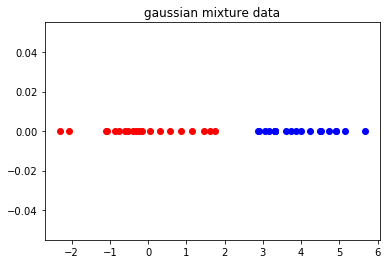

In [2]:
np.random.seed(1)
x1 = np.random.normal(0, 1, 20)
x2 = np.random.normal(4, 1, 20)
y1 = np.zeros_like(x1)
y2 = y1
x = np.hstack([x1, x2])

plt.plot(x1, y1, 'ro', label='cluster1')
plt.plot(x2, y2, 'bo', label='cluster2')
plt.title('gaussian mixture data')

### 给定数据x， 即H潜变量可能取值[0, 1]
求出参数的分布

In [3]:
def norm(x, u, sigma):
    """
    正太分布函数
    """
    f = 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(x-u)**2/(2*sigma**2))
    
    return f

def log_norm(x, u,  sigma_square):
    f = -.5*(np.log(sigma_square) \
        + np.log(2*np.pi) \
        + (x-u)**2/sigma_square)
    
    return f

def grad_sigma_square(x, u, sigma_square):
    """
    对数正太分布对sigma平方的梯度
    """
    _g = -1/(2*sigma_square)*(1 - (x-u)**2/sigma_square)

    return _g

def grad_u(x, u, sigma_square):
    """对数正太分布对sigma平方的梯度"""
    return (x-u)/sigma_square

from scipy.stats import norm as _norm
def test_norm():
    x = 2
    sigma = 1
    u = 1
    sigma_square = sigma**2
    px = norm(x,u, sigma)
    assert np.isclose(px, _norm(u, sigma).pdf(x))
    log_px = log_norm(x, u, sigma_square)
    assert np.log(px) == log_px
    g_s = grad_sigma_square(x, u, sigma_square)
    assert np.isclose(g_s, 0)
    g_u = grad_u(x, u, sigma_square)
    assert np.isclose(g_u, 1)
    print('all test pass.')
test_norm()

all test pass.


### 初始化参数

In [4]:
# init parameter
def softmax(x):
    """
    把每行(scores通常)变成prob
    """
    shape = len(x.shape)
    x = np.atleast_2d(x)
    x -= x.max(axis=1, keepdims=True)
    _exp = np.exp(x)
    prob = _exp/_exp.sum(axis=1)
    if shape == 1:
        return prob.flatten()
    return prob

## E步:
p(H|X) = p(X|H)p(H)/p(X)  
其中 P(X) = sum_H(p(X|H)p(H)), 就是联合概率的归一化

In [5]:
def Qi(_x, PH, PXH, log=True):
    pxh = []
    for h in range(len(PH)):
        _ph = PH[h]
        _u, _sigma_square = PXH[h,:]
        _pxh = log_norm(_x, _u, _sigma_square)
        pxh.append(np.log(_ph) + _pxh)
    log_phx = np.asarray(pxh) - np.log(sum(np.exp(pxh)))
    return log_phx

def M_step(x, PH, PXH):
    logphx = []
    logpxh = []
    for _x in x: 
        _logpxh = []
        for h in range(len(PH)):
            _ph = PH[h]
            _u, _sigma_square = PXH[h,:]
            _pxh = log_norm(_x, _u, _sigma_square)
            _logpxh.append(np.log(_ph) + _pxh)
        log_phx = np.asarray(_logpxh) - np.log(sum(np.exp(_logpxh)))
        logphx.append(log_phx)
        logpxh.append(_logpxh)
    logphx = np.vstack(logphx)
    w = np.exp(logphx)
    logpxh = np.reshape(logpxh, [-1, len(PH)])
    likelihood = np.sum(w*(logpxh - logphx))
    return w, likelihood

### 多个样本怎么处理？
在计算Q时，样本与样本之间是独立可分，因此可以分开计算  
M步时，样本集的对数似然是个样本的似然的和

### M步：
1. 写出似然函数
2. 求各参数的梯度
3. 另梯度=0，求极值

待估计分布：
- p(X|H) 是正太分布 [miu， sigma]
- p(H) [p1, p2]

In [6]:
def E_step(w, x):
    PH = np.mean(w, axis=0)
    us = (w*x[:,np.newaxis]).sum(axis=0)/w.sum(axis=0)
    sigma_squares = np.sum(w*(x[:, np.newaxis] - us)**2, axis=0)/w.sum(axis=0)
    PXH = np.vstack([us, sigma_squares]).T
    return PH, PXH

In [7]:
def mixture_gaussian(x, k):
    PH = softmax(np.random.randn(k))
    PXH = softmax(np.random.randn(2, k))
    _likelihood = -1
    epsilon = 1e-5
    while True:
        w, likelihood = M_step(x, PH, PXH)
        delta = abs(likelihood - _likelihood)
        if delta < epsilon:
            break
        _likelihood = likelihood
        PH, PXH = E_step(w, x)
    return PH, PXH
PH, PXH = mixture_gaussian(x, 2)

In [8]:
def clustering(x, PH, PXH):
    """
    p(H|X)
    """
    phx = np.vstack([Qi(_x, PH, PXH) for _x in x])
    yhat = np.argmax(phx, axis=1)
    return yhat

def test_clustering():
    assert sum(clustering(x, PH, PXH)) == len(x)//2
    print('gaussian mixture test pass')
test_clustering()

gaussian mixture test pass


# todo: HMM